In [1]:
#####Hierarchical Tensor Factorization model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import itertools
import scipy.stats as ss
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [2]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 10000   #ユーザー数
item = 3000   #アイテム数
context = 24   #コンテキスト数
pt = np.random.poisson(np.random.gamma(25, 1/0.25, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #総レコード数
vec_k = np.repeat(1, k)

In [3]:
##IDとインデックスの設定
#IDの設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [4]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [5]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
phi = np.random.dirichlet(np.repeat(0.25, context), topic)
theta = np.random.dirichlet(np.repeat(0.25, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(context))
context_dt = sparse.coo_matrix((np.repeat(1, hhpt), (context_id, range(hhpt))), shape=(context, hhpt)).tocsr()   #スパース行列の設定
context_n = np.array(np.sum(context_dt, axis=1)).reshape(-1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
#アイテムとコンテキストのインデックスを作成
index = np.array(range(hhpt))
item_list = [j for j in range(item)]
context_list = [j for j in range(context)]
for j in range(item):
    item_list[j] = index[item_id==j]
for j in range(context):
    context_list[j] = index[context_id==j]

In [7]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##パラメータを生成
    #階層モデルのパラメータを生成
    alpha_u = 5.5; alpha_ut = alpha_u
    tau_u = 0.75; tau_v = 1.0; tau_c = 0.5
    tau_ut = tau_u; tau_vt = tau_v; tau_ct = tau_c
    Cov_u = np.diag(np.repeat(0.5, k))
    Cov_v = np.diag(np.repeat(0.5, k))
    Cov_c = np.diag(np.repeat(0.5, k))
    Cov_ut = Cov_u; Cov_vt = Cov_v; Cov_ct = Cov_c

    #モデルパラメータを生成
    Sigma = 0.4; Sigmat = Sigma
    beta_u = np.random.normal(alpha_u, tau_u, hh)
    beta_v = np.random.normal(0, tau_v, item)
    beta_c = np.random.normal(0, tau_c, context)
    beta_ut = beta_u; beta_vt = beta_v; beta_ct = beta_c
    theta_u = np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
    theta_v = np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)
    theta_c = np.random.multivariate_normal(np.repeat(0, k), Cov_c, context)
    theta_ut = theta_u; theta_vt = theta_v; theta_ct = theta_c
    
    #正規分布からスコアを生成
    uvc = np.dot(theta_u[user_id, ] * theta_v[item_id, ] * theta_c[context_id, ], vec_k)
    mu = beta_u[user_id] + beta_v[item_id] + beta_c[context_id] + uvc
    y_vec = mu + np.random.normal(0, Sigma, hhpt)

    #収束条件
    if (np.mean(y_vec) < 6.0) & (np.mean(y_vec) > 4.5) & (np.std(y_vec) > 1.75) & (np.std(y_vec) < 2.25):
        break

1


[5.55393973 5.55341902]
[1.80237047 1.79241659]


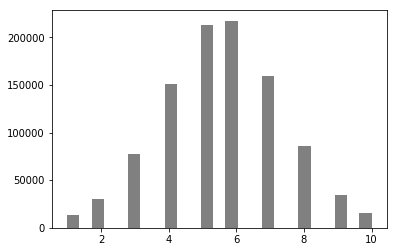

In [8]:
##応答変数をスコアに変換
y = np.round(y_vec)
y[y > 10] = 10; y[y < 1] = 1
print(np.append(np.mean(y_vec), np.mean(y)))
print(np.append(np.std(y_vec), np.std(y)))
plt.hist(y, bins=25, color="grey", histtype="barstacked")
plt.show()

In [9]:
#####モンテカルロEMアルゴリズムでHierarchical Tensor Factorization modelを推定####
##アルゴリズムの設定
LL1 = -1000000000   #対数尤度の初期値
tol = 2.5
iter = 1
dl = 100
L = 500   #モンテカルロサンプリング数

In [10]:
##インデックスの設定
ui_id = [i for i in range(hh)]
uc_id = [i for i in range(hh)]
iu_id = [j for j in range(item)]
ic_id = [j for j in range(item)]
cu_id = [j for j in range(context)]
cv_id = [j for j in range(context)]
for i in range(hh):
    ui_id[i] = item_id[user_list[i]]
    uc_id[i] = context_id[user_list[i]]
for j in range(item):
    iu_id[j] = user_id[item_list[j]]
    ic_id[j] = context_id[item_list[j]]
for j in range(context):
    cu_id[j] = user_id[context_list[j]]
    cv_id[j] = item_id[context_list[j]]

In [11]:
##パラメータの真値
#階層モデルのパラメータ
alpha_u = alpha_ut
tau_u = tau_ut; tau_v = tau_vt; tau_c = tau_ct
Cov_u = Cov_ut
Cov_v = Cov_vt
Cov_c = Cov_ct
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_c = np.linalg.inv(Cov_c)

#モデルパラメータの生成
Sigma = Sigmat
beta_u = beta_ut
beta_v = beta_vt
beta_c = beta_ct
theta_u = theta_ut
theta_v = theta_vt
theta_c = theta_ct

In [12]:
##パラメータの初期値
#階層モデルのパラメータ
alpha_u = np.mean(y)
tau_u = 0.3; tau_v = 0.3; tau_c = 0.5
Cov_u = np.diag(np.repeat(0.25, k))
Cov_v = np.diag(np.repeat(0.5, k))
Cov_c = np.diag(np.repeat(0.5, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_c = np.linalg.inv(Cov_c)

#モデルパラメータの生成
Sigma = 1.0
beta_u = np.random.normal(alpha_u, tau_u, hh)
beta_v = np.random.normal(0, tau_v, item)
beta_c = np.random.normal(0, tau_c, context)
theta_u = np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
theta_v = np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)
theta_c = np.random.multivariate_normal(np.repeat(0, k), Cov_c, context)

In [13]:
##テンソルと期待値の初期値
#変量効果とテンソルの設定
dl = 100
beta_u_vec = beta_u[user_id]
beta_v_vec = beta_v[item_id]
beta_c_vec = beta_c[context_id]
uvc = np.dot(theta_u[user_id, ] * theta_v[item_id, ] * theta_c[context_id, ], vec_k)

In [14]:
##対数尤度の基準値と初期値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.std(y)))

#真値での対数尤度
uvc_t = np.dot(theta_ut[user_id, ] * theta_vt[item_id, ] * theta_ct[context_id, ], vec_k)
mu = beta_ut[user_id] + beta_vt[item_id] + beta_ct[context_id] + uvc_t
LLbest = np.sum(scipy.stats.norm.logpdf(y, mu, Sigmat))

#対数尤度の初期値
mu = beta_u_vec + beta_v_vec + beta_c_vec + uvc
LL1 = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))
print(np.array([LL1, LLst, LLbest]))

[-3011516.24680611 -1997835.46000534  -800092.36495383]


In [15]:
####モンテカルロEMアルゴリズムでパラメータを推定####
while (dl > tol):   #dlがtol以上なら繰り返す
    
    ##ユーザーのランダム効果をサンプリング
    #データの設定
    y_er = y - beta_v_vec - beta_c_vec - uvc

    #事後分布のパラメータ
    u_mu = (np.array(np.dot(user_dt, sparse.csr_matrix(y_er.reshape(hhpt, 1))).todense()).reshape(-1))/pt
    weights = np.power(tau_u, 2) / (np.power(Sigma, 2)/pt + np.power(tau_u, 2))   #重み係数
    mu_par = weights*u_mu + (1-weights)*alpha_u   #事後分布の平均

    #正規分布から変量効果をサンプリング
    beta_mc = np.zeros((hh, L))
    for j in range(L):
        beta_mc[:, j] = np.random.normal(mu_par, np.sqrt(1 / (1/np.power(tau_u, 2) + pt/np.power(Sigma, 2))), hh)
    beta_u = np.mean(beta_mc, axis=1)   #モンテカルロ平均    
    vars_u1 = np.var(beta_mc, axis=1)   #モンテカルロ誤差
    beta_u_vec = beta_u[user_id]

    ##アイテムのランダム効果をサンプリング
    #データの設定
    y_er = y - beta_u_vec - beta_c_vec - uvc

    #事後分布のパラメータ
    v_mu = np.repeat(0.0, item)
    for j in range(item):
        v_mu[j] = np.mean(y_er[item_list[j]])
    weights = np.power(tau_v, 2) / (np.power(Sigma, 2)/item_n + np.power(tau_v, 2))   #重み係数
    mu_par = weights*v_mu   #事後分布の平均

    #正規分布から事後分布をサンプリング
    beta_mc = np.zeros((item, L))
    for j in range(L):
        beta_mc[:, j] = np.random.normal(mu_par, np.sqrt(1 / (1/np.power(tau_v, 2) + item_n/np.power(Sigma, 2))), item)
    beta_v = np.mean(beta_mc, axis=1)   #モンテカルロ平均    
    vars_v1 = np.var(beta_mc, axis=1)   #モンテカルロ誤差
    beta_v_vec = beta_v[item_id]

    ##コンテキストのランダム効果をサンプリング
    #データの設定
    y_er = y - beta_u_vec - beta_v_vec - uvc

    #事後分布のパラメータ
    c_mu = np.repeat(0.0, context)
    for j in range(context):
        c_mu[j] = np.mean(y_er[context_list[j]])
    weights = np.power(tau_c, 2) / (np.power(Sigma, 2)/context_n + np.power(tau_c, 2))   #重み係数
    mu_par = weights*c_mu   #事後分布の平均

    #正規分布から事後分布をサンプリング
    beta_mc = np.zeros((context, L))
    for j in range(L):
        beta_mc[:, j] = np.random.normal(mu_par, np.sqrt(1 / (1/np.power(tau_c, 2) + context_n/np.power(Sigma, 2))), context)
    beta_c = np.mean(beta_mc, axis=1)   #モンテカルロ平均    
    vars_c1 = np.var(beta_mc, axis=1)   #モンテカルロ誤差
    beta_c_vec = beta_c[context_id]
    

    ##ユーザーの特徴行列をサンプリング
    #データの設定
    y_er = y - beta_u_vec - beta_v_vec - beta_c_vec

    #事後分布のパラメータ
    vars_u2 = 0
    for i in range(hh):
        X = theta_v[ui_id[i], ] * theta_c[uc_id[i], ]
        Xy = np.dot(X.T, y_er[user_list[i]])
        inv_XXV = np.linalg.inv(np.dot(X.T, X) + inv_Cov_u)
        mu_par = np.dot(inv_XXV, Xy)

        #多変量正規分布から特徴行列をサンプリング
        theta_mc = np.random.multivariate_normal(mu_par, np.power(Sigma, 2)*inv_XXV, L)
        theta_u[i, ] = np.mean(theta_mc, axis=0)
        vars_u2 += np.sum(np.diag(np.cov(theta_mc, rowvar=0)))

    ##アイテムの特徴行列をサンプリング
    #事後分布のパラメータ
    vars_v2 = 0
    for j in range(item):
        X = theta_u[iu_id[j], ] * theta_c[ic_id[j], ]
        Xy = np.dot(X.T, y_er[item_list[j]])
        inv_XXV = np.linalg.inv(np.dot(X.T, X) + inv_Cov_v)
        mu_par = np.dot(inv_XXV, Xy)

        #多変量正規分布から特徴行列をサンプリング
        theta_mc = np.random.multivariate_normal(mu_par, np.power(Sigma, 2)*inv_XXV, L)
        theta_v[j, ] = np.mean(theta_mc, axis=0)
        vars_v2 += np.sum(np.diag(np.cov(theta_mc, rowvar=0)))

    ##コンテキストの特徴行列をサンプリング
    #事後分布のパラメータ
    vars_c2 = 0
    for j in range(context):
        X = theta_u[cu_id[j], ] * theta_v[cv_id[j], ]
        Xy = np.dot(X.T, y_er[context_list[j]])
        inv_XXV = np.linalg.inv(np.dot(X.T, X) + inv_Cov_c)
        mu_par = np.dot(inv_XXV, Xy)

        #多変量正規分布から特徴行列をサンプリング
        theta_mc = np.random.multivariate_normal(mu_par, np.power(Sigma, 2)*inv_XXV, L)
        theta_c[j, ] = np.mean(theta_mc, axis=0)
        vars_c2 += np.sum(np.diag(np.cov(theta_mc, rowvar=0)))

    #テンソルのパラメータを更新
    uvc = np.dot(theta_u[user_id, ] * theta_v[item_id, ] * theta_c[context_id, ], vec_k)


    ##Mステップでパラメータを更新
    #観測モデルの誤差パラメータを更新
    er = y - beta_u_vec - beta_v_vec - beta_c_vec - uvc   
    Sigma = np.std(er)

    #ユーザの階層モデルのパラメータを更新
    alpha_u = np.mean(beta_u)
    tau_u = np.sqrt((sum(vars_u1) + np.sum(np.power(beta_u - alpha_u, 2))) / hh)
    theta_mu = np.repeat(np.mean(theta_u, axis=0), hh).reshape(hh, k, order="F")
    Cov_u = np.diag(np.repeat(np.sum(np.diag(vars_u2 + np.dot((theta_u - theta_mu).T, theta_u - theta_mu))) / (k*hh), k))
    inv_Cov_u = np.linalg.inv(Cov_u)

    #アイテムの階層モデルのパラメータを更新
    tau_v = np.sqrt((sum(vars_v1) + np.sum(np.power(beta_v - np.mean(beta_v), 2))) / item)
    theta_mu = np.repeat(np.mean(theta_v, axis=0), item).reshape(item, k, order="F")
    Cov_v = np.diag(np.repeat(np.sum(np.diag(vars_v2 + np.dot((theta_v - theta_mu).T, theta_v - theta_mu))) / (k*item), k))
    inv_Cov_v = np.linalg.inv(Cov_v)

    ##アルゴリズムの収束判定
    mu = beta_u_vec + beta_v_vec + beta_c_vec + uvc   #完全データの期待値
    LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))   #完全データの対数尤度を更新
    iter = iter + 1
    dl = LL - LL1
    LL1 = LL
    print(np.round([LL, LLst, LLbest], 1))

[-1534877.2 -1997835.5  -800092.4]
[-1472289.7 -1997835.5  -800092.4]
[-1446560.6 -1997835.5  -800092.4]
[-1429883.3 -1997835.5  -800092.4]
[-1414699.6 -1997835.5  -800092.4]
[-1396220.  -1997835.5  -800092.4]
[-1376100.4 -1997835.5  -800092.4]
[-1360662.7 -1997835.5  -800092.4]
[-1346998.7 -1997835.5  -800092.4]
[-1328508.8 -1997835.5  -800092.4]
[-1296109.7 -1997835.5  -800092.4]
[-1245435.1 -1997835.5  -800092.4]
[-1179517.8 -1997835.5  -800092.4]
[-1111041.3 -1997835.5  -800092.4]
[-1057389.9 -1997835.5  -800092.4]
[-1011287.9 -1997835.5  -800092.4]
[ -977320.8 -1997835.5  -800092.4]
[ -957763.3 -1997835.5  -800092.4]
[ -921486.7 -1997835.5  -800092.4]
[ -870506.2 -1997835.5  -800092.4]
[ -828162.4 -1997835.5  -800092.4]
[ -820044.6 -1997835.5  -800092.4]
[ -816966.3 -1997835.5  -800092.4]
[ -815177.8 -1997835.5  -800092.4]
[ -813847.9 -1997835.5  -800092.4]
[ -812825.  -1997835.5  -800092.4]
[ -811838.4 -1997835.5  -800092.4]
[ -810214.3 -1997835.5  -800092.4]
[ -805721.2 -1997835

In [16]:
Cov_v

array([[8.79509235, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 8.79509235, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 8.79509235, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 8.79509235, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 8.79509235,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        8.79509235, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 8.79509235, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       